# ML projet - Groupe 3

# Pretraitement

In [137]:
import pandas as pd
from gensim.models import Word2Vec
import nltk
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import enchant
import numpy as np
from collections import Counter
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random
from sklearn.model_selection import KFold



from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import emoji


#nltk.download('punkt_tab')
#nltk.download("words")
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger_eng')
#%matplotlib qt
%matplotlib inline

In [138]:
df = pd.read_csv("scitweets_export.tsv", sep = "\t")

In [139]:
len(df[df["science_related"] == 0])/(len(df))

0.6710526315789473

### Enlever (.,\\@#:';"“”’[]), les chiffres et les liens (http) de chaque tweet

In [140]:
text = []
all_text = list(df["text"])
for t in all_text:
    a = re.sub("[\.,/\\@:;\"\'0-9“”’\[\]]", " \1 ", t)
    a = re.sub("http\S*", "", a) #Enlever les liens
    a = re.sub("#\S*", "", a) #Enlever les tags
    a = a.lower()
    text.append(a)
#for sentence in text:  

In [141]:
#Créer une liste des phrases ou chaque phrase est une liste de mots.
text_sep = [word_tokenize(t) for t in text]

In [142]:
#len(text_sep)
text_sep[-3]

['whats', 'the', 'uber', 'support', 'team', 'email', 'address', '?']

## Standardizer chaque phrases. 
- Convertir les noms pluriels en leur forme singuliers
- Convertir les conjugaison de chaque verbe en leur infinitif
- Standardiser les ajectives et les adverbes

In [143]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):  # Adjectif
        return wordnet.ADJ
    elif tag.startswith('V'):  # Verbe
        return wordnet.VERB
    elif tag.startswith('N'):  # Nom
        return wordnet.NOUN
    elif tag.startswith('R'):  # Adverbe
        return wordnet.ADV
    else:
        return wordnet.NOUN 

    
lemmatizer = WordNetLemmatizer()
refined_tweets = []
for tweet in text_sep:
    pos_tags = pos_tag(tweet)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    refined_tweets.append(lemmatized_words)



## Laisser une trace pour les emojis

In [144]:
emoji_list = []
has_emoji = False 
for sentence in refined_tweets:
    has_emoji = False
    for word in sentence:
        for char in word:
            if emoji.is_emoji(char):
                has_emoji = True
                break
    if has_emoji is True:
        emoji_list.append(1)
    else:
        emoji_list.append(0)
df["has_emoji"] = emoji_list

In [145]:
def remake_sentences(sentence_list):
    sentence_join = []
    phrase = ""
    for sentence in sentence_list:
        for word in sentence:
            phrase = phrase + word + " "
        sentence_join.append(phrase)
        phrase = ""
    return(sentence_join)

In [146]:
def plot_word_distribution(word_list):
    word_list_flat = [word for sublist in word_list for word in sublist]
    word_counts = Counter(word_list_flat)
    # 3. Afficher les 10 mots les plus fréquents (optionnel)
    most_common = word_counts.most_common(100)
    #print(most_common[0:10])
    words, counts = zip(*most_common)
    
    # 4. Tracer avec seaborn
    #plt.figure(figsize=(30, 12))
    plt.figure(figsize=(16, 8)).gca()
    sns.barplot(x=list(words), y=list(counts))
    plt.title("Distribution des mots")
    plt.ylabel("Nombre d'occurrences")
    plt.xlabel("Mots")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/home/cm/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 1 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cm/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 1 missing from current font.
  font.set_text(s, 0, flags=flags)


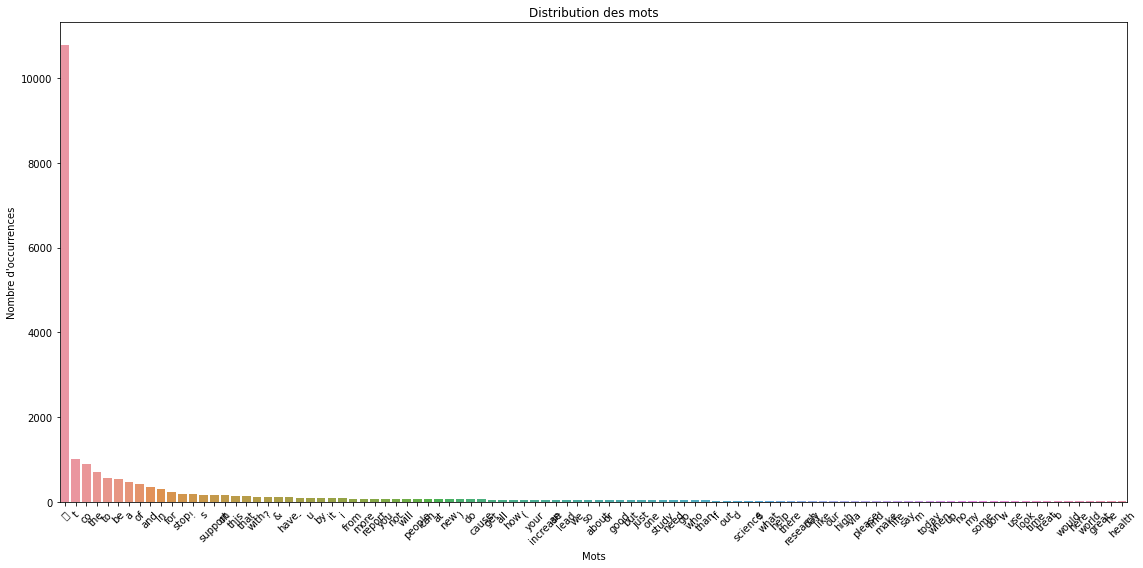

In [147]:
plot_word_distribution(refined_tweets)

In [148]:
mots_a_supprimer = ["the", "to", "a", "of", "and", "in", "for", "on", "this", 
                    "with", "that", "have", "by", "it", "from", "be", "do", 
                    "t", " ", "to", "\x01", "co", "no", "out", "d", "our", "so",
                   "(", ")", "your", "but", "if", "than", "\x01"]

# Supprimer toutes les occurrences de "the"
filtered_words = [[word for word in row if word not in mots_a_supprimer] for row in refined_tweets]
#filtered_words = re.sub(r"[\x00-\x1F]", filtered_words)

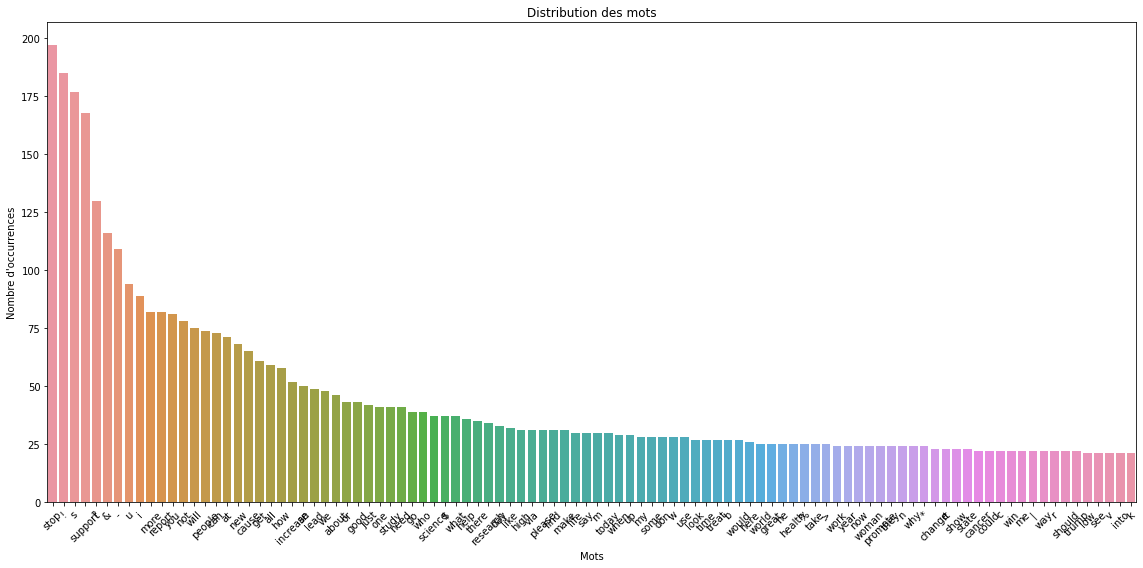

In [149]:
plot_word_distribution(filtered_words)

In [150]:
X = remake_sentences(filtered_words)  # Utiliser uniquement la colonne 'text' comme feature
y_binary = df['science_related']  # Étiquette binaire (scientifique ou non)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=1)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_vec = vectorizer.fit_transform(X)  # Apprentissage et transformation sur l'entraînement

X_train_vec = vectorizer.fit_transform(X_train)  # Apprentissage et transformation sur l'entraînement


X_test_vec = vectorizer.transform(X_test)

In [151]:
len(X_test_vec.data)

2128

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Création du pipeline
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction
y_pred = pipeline.predict(X_test)

# Évaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[139   7]
 [ 53  29]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       146
           1       0.81      0.35      0.49        82

    accuracy                           0.74       228
   macro avg       0.76      0.65      0.66       228
weighted avg       0.75      0.74      0.70       228



In [153]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


#X_train, X_test, y_train, y_test = train_test_split(list(df["text"]), list(df["science_related"]), test_size=0.2, random_state=42)

# Création du pipeline
pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

scores = cross_val_score(pipeline, list(df["text"]), list(df["science_related"]), cv=5, scoring='f1')
print("F1 scores:", scores)
print("Moyenne:", scores.mean())

F1 scores: [0.31914894 0.60504202 0.4957265  0.70072993 0.63865546]
Moyenne: 0.5518605675791208


In [154]:
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd


X_train, X_test, y_train, y_test = train_test_split(list(df["text"]), list(df["science_related"]), test_size=0.2, random_state=42)

# Pipeline avec SVM
pipeline_svm = ImbPipeline([
    ('vectorizer', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(class_weight='balanced', kernel='linear', random_state=42))
])

# Entraînement
pipeline_svm.fit(X_train, y_train)

# Prédiction
y_pred = pipeline_svm.predict(X_test)

# Évaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[132  14]
 [ 25  57]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       146
           1       0.80      0.70      0.75        82

    accuracy                           0.83       228
   macro avg       0.82      0.80      0.81       228
weighted avg       0.83      0.83      0.83       228



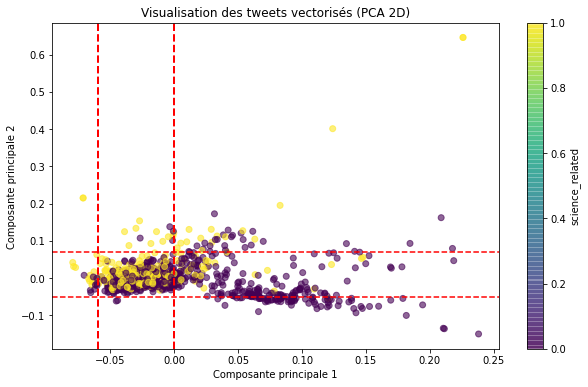

In [155]:
# Réduire la dimension à 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vec.toarray())  # Convertir la matrice creuse en tableau dense

# Visualiser les données en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, cmap='viridis', alpha=0.6)
plt.colorbar(label='science_related')
plt.title('Visualisation des tweets vectorisés (PCA 2D)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')

plt.axvline(x=-0.06, color='red', linestyle='--', linewidth=2)  
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)  

plt.axhline(y=0.07, color='red', linestyle='--')
plt.axhline(y=-0.05, color='red', linestyle='--')

plt.show()

In [156]:
len(refined_tweets)

1140

In [157]:
pca_df = pd.DataFrame({
    'pca1': X_pca[:, 0],
    'pca2': X_pca[:, 1],
    'label': y_binary,
    'tweet': filtered_words  # doit être dans le même ordre que X_train
})

In [105]:
print(pca_df['pca1'].min(), pca_df['pca1'].max())
print(pca_df['pca2'].min(), pca_df['pca2'].max())

-0.08623697698364022 0.2517037492972924
-0.14729107119292217 0.7191086346164846


In [106]:
zone = pca_df[
    (pca_df['pca2'] > -0.05) & (pca_df['pca2'] < 0.07) &  # limites vertical
    (pca_df['pca1'] > -0.06) & (pca_df['pca1'] < 0.0)    # limites horizontal
]

In [108]:
print(len(zone[zone["label"] == 0]))
print(len(zone[zone["label"] == 1]))

446
303


In [109]:
zone.to_csv("pca_zone.csv", index=False)

In [110]:
df[df["science_related"] == 1].to_csv("science_related.csv", index=False)

In [303]:
# Réduire la dimension à 2D avec t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=15)
X_train_tsne = tsne.fit_transform(X_train_vec.toarray())

# Visualiser les données en 2D
plt.figure(figsize=(10, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.colorbar(label='science_related')
plt.title('Visualisation des tweets vectorisés (t-SNE 2D)')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.show()

### Le code desous montre que 70% de mots dans les tweet sont valide (dans les dictionnaire anglais)

In [24]:
len(model.wv["science"])

NameError: name 'model' is not defined

In [ ]:
len(refined_tweets)

In [ ]:
s = "a " + "a"
s+= " b"
s

In [25]:
#import numpy as np
#from sklearn.feature_extraction.text import TfidfVectorizer

# Exemple de corpus (phrases en texte brut)
sentences = [
    "The scientific discovery was groundbreaking",
    "Physics and chemistry are fundamental sciences",
    "The research paper introduced a new concept"
]

# Étape 1: Calculer le TF-IDF sur toutes les phrases
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(refined_tweets_join)
tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))

# Simulons un modèle Word2Vec où chaque mot est représenté par un vecteur de taille 200
# (En pratique, tu utiliserais un vrai modèle Word2Vec comme gensim)
word2vec_model = model.wv

# Fonction pour convertir une phrase en un vecteur TF-IDF pondéré
def sentence_to_tfidf_w2v(sentence):
    words = sentence.split()  # Tokenisation simple (mieux vaut utiliser nltk/spacy)
    vectors = []
    weights = []
    
    for word in words:
        if word in word2vec_model and word in tfidf_scores:  # Vérifier si le mot a un vecteur
            vectors.append(word2vec_model[word] * tfidf_scores[word])  # Pondérer par TF-IDF
            weights.append(tfidf_scores[word])

    if len(vectors) == 0:  # Si aucun mot n'a de vecteur, renvoyer un vecteur nul
        return np.zeros(200)
    
    return np.sum(vectors, axis=0) / np.sum(weights)  # Moyenne pondérée

# Transformer chaque phrase en un vecteur de taille 200
X_transformed = np.array([sentence_to_tfidf_w2v(sentence) for sentence in refined_tweets_join])


NameError: name 'model' is not defined

In [26]:
len(X_transformed)

NameError: name 'X_transformed' is not defined

In [27]:
df

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1135,1255,1340455669443350528,@LaylaFanucci @realDonaldTrump I'm sorry but w...,1,1.0,0.0,0.0
1136,1256,1340689510569549824,"Dear #NIN applicants, you can kindly download ...",0,0.0,0.0,0.0
1137,1258,1341155832793165825,Whats the uber support team email address?,0,0.0,0.0,0.0
1138,1259,1344167355648241664,House passes bill to increase stimulus checks ...,0,0.0,0.0,0.0


In [102]:
df["science_related"]

0       0
1       0
2       1
3       1
4       1
       ..
1135    1
1136    0
1137    0
1138    0
1139    0
Name: science_related, Length: 1140, dtype: int64

In [159]:
data_vec = list(zip(X_transformed, df["science_related"]))

In [160]:
random.shuffle(data_vec)

train_quantity  = 0.8

train_data = data_vec[0:int(len(data_vec)*0.8)]
test_data = data_vec[int(len(data_vec)*0.8)::]

x = [val[0] for val in data_vec]
y = [val[1] for val in data_vec]

x_train = [val[0] for val in train_data]
y_train = [val[1] for val in train_data]


x_test = [val[0] for val in test_data]
y_test = [val[1] for val in test_data]


clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

# SVM
svm = SVC(kernel="rbf")
svm.fit(x_train, y_train)

SVC()

In [162]:
len(x)

1140

In [163]:
scores = cross_val_score(svm, x, y, scoring='accuracy', cv=10, n_jobs=-1)
scores

array([0.6754386 , 0.6754386 , 0.6754386 , 0.6754386 , 0.6754386 ,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667])

In [154]:
y_pred_rf = clf.predict(x_test)

# Prédictions avec SVM
y_pred_svm = svm.predict(x_test)

In [153]:
# Évaluation Random Forest
print("Performance du Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Évaluation SVM
print("\nPerformance du SVM:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Performance du Random Forest:
              precision    recall  f1-score   support

           0       0.68      0.98      0.81       156
           1       0.25      0.01      0.03        72

    accuracy                           0.68       228
   macro avg       0.47      0.50      0.42       228
weighted avg       0.55      0.68      0.56       228

Accuracy: 0.6754385964912281

Performance du SVM:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       156
           1       0.00      0.00      0.00        72

    accuracy                           0.68       228
   macro avg       0.34      0.50      0.41       228
weighted avg       0.47      0.68      0.56       228

Accuracy: 0.6842105263157895


/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking

# Convertir chaque phrase en une séquence de vecteurs Word2Vec
def vectorize_sentence(sentence, model, max_length=20):
    words = sentence
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    # Padding avec des zéros si la phrase est trop courte
    while len(word_vectors) < max_length:
        word_vectors.append(np.zeros(model.vector_size))
    
    # Troncature si trop long
    return np.array(word_vectors[:max_length])

word_model = []
for sentence in refined_tweets:
    a = vectorize_sentence(sentence, model)
    word_model.append(a)

# Créer les données sous forme de séquences de vecteurs
#X = np.array([vectorize_sentence(text, word2vec_model) for text in df["text"]])
X = np.array(word_model)

y = df["science_related"].values

# Définir le modèle LSTM
model = Sequential([
    Masking(mask_value=0.0, input_shape=(20, model.vector_size)),  # Ignorer les zéros
    LSTM(128, return_sequences=False),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")  # Classification binaire
])

# Compilation et entraînement
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(X, y, epochs=10, batch_size=16, validation_split=0.2)


2025-03-24 10:54:59.100599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-24 10:54:59.100641: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-24 10:55:02.356933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-24 10:55:02.356968: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-24 10:55:02.357008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc): /proc/driver/nvidia/version does not exist
2025-03-24 10:55:02.357472: I tensorflow/core/platform/cpu_feature_guard.c

Epoch 1/10
57/57 [==============================] - 7s 55ms/step - loss: 0.6387 - accuracy: 0.6689 - val_loss: 0.6756 - val_accuracy: 0.6535
Epoch 2/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6315 - accuracy: 0.6754 - val_loss: 0.6541 - val_accuracy: 0.6535
Epoch 3/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6321 - accuracy: 0.6754 - val_loss: 0.6490 - val_accuracy: 0.6535
Epoch 4/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6296 - accuracy: 0.6754 - val_loss: 0.6476 - val_accuracy: 0.6535
Epoch 5/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6279 - accuracy: 0.6754 - val_loss: 0.6453 - val_accuracy: 0.6535
Epoch 6/10
57/57 [==============================] - 1s 26ms/step - loss: 0.6293 - accuracy: 0.6754 - val_loss: 0.6489 - val_accuracy: 0.6535
Epoch 7/10
57/57 [==============================] - 2s 27ms/step - loss: 0.6295 - accuracy: 0.6754 - val_loss: 0.6504 - val_accuracy: 0.6535
Epoch 8/10
57